####  Map Area :   Shenzhen, Guangdong ,China

[Dataset](https://mapzen.com/data/metro-extracts/metro/shenzhen_china/) This extract actually contains information for the Shenzhen City.

## 1. Problems Encountered in the Map

After initially downloading a small sample size of the Shenzhen City and running it with a provisional data.py file, I found the three main problems in the dataset, which I will discuss in the following order:

Overabbreviated street type names ("盐梅路 Yanmei Rd") 

Pinyin spelling of Chinese words ("南山大道 Nanshan Dadao") 

Inconsistent city name ("深圳市","广东省深圳市") 

### Overabbreviated Street Names

After searching the street key type "addr:street" on the sample osm file with grep command, I found many street name has overabbreviated.

grep command:  
grep -i  "addr:street" sample.osm

searching result:
<tag k="addr:street" v="罗芳路 Luofang Rd" />
<tag k="addr:street" v="文锦中路 Wenjin Middle Rd" />
<tag k="addr:street" v="香梅路 Xiangmei Rd" />
......

I solved the overabbreviated problem by first use the regular expression to filter out the street type, Then using a mapping dictionary (street_abbrev_mapping in config.py) to map the abbreviated name to countpart full name

street_abbrev_mapping  = { 
            "St": "Street",
            "St.": "Street",
            "str": "Street",
            "Ave": "Avenue",
            "Ave.":"Avenue",
            "AV": "Avenue",            
            "Rd.":  "Road",
            "Rd":  "Road",
            "RD": "Road",            
            "PKWY": "Parkway",
            "Pkwy": "Parkway",            
            "Blvd": "Boulevard",
            "Blvd.": "Boulevard",
            "Boulavard": "Boulevard",
            "Pl": "Place",
            "Pl.": "Place",
            "Ln": "Lane",
            "Ln.": "Lane",
            "Dr": "Drive",
            "Dr.": "Drive"
            }

In [2]:
%run audit.py shenzhen_sample.osm -t street -p overabbreviated

audit.py: auditing the tag street for overabbreviated problem ...
景田北一街 Jingtian North 1st St => 景田北一街 Jingtian North 1st Street
正云路 Zhengyun Rd => 正云路 Zhengyun Road


### Pinyin spelling of Chinese Words

Pinyin spelling of chinese words is an interesting case. Often times, the chinese pinyin of a word is written in the english street name. For example "南山大道 Nanshan Dadao" instead of "南山大道 Nanshan Avenue ",  both street name "Nanshan" and street type "Dadao" are using pinyin word.(see http://wiki.openstreetmap.org/wiki/WikiProject_China#Generics_in_Chinese).

Because pinyin spelling street name is a common custom. So I not deal with street name and instead focus on fix pinyin spelling street type problem. I solved the problem by using a mapping dictionay (pinyin_mapping in config.py) to map pinyin word to countpart english names.

pinyin_mapping = {
    "Dadao":"Avenue", 
    "Jie":"Street",
    "Dajie":"Main Street",
    "Lu":"Road",    
    "Dayuan":"Courtyard",
    "Dong":"East",
    "Xi":"West",
    "Nan":"South",
    "Bei":"North",
    "Zhong":"Middle",
    "Qiao":"Bridge",
    u"Gaoxin S.":u"高新区南",
    "S.":"South",
    "N.":"North",
    u"Houhaibin":u"华强北路 Huangqiang North Road"
}


In [3]:
%run audit.py shenzhen_sample.osm -t street -p pinyin

audit.py: auditing the tag street for pinyin problem ...
KeYuan Lu => KeYuan Road
桃园路 Taoyuan Lu => 桃园路 Taoyuan Road


### Inconsist city name

City name (addr:city) is inconsist, sometime is chinese ("深圳市","广东省深圳市"), sometime is pinyin word (“Shenzhen""). 
I solved the problem by using a mapping dictionay to map pinyin word to a unified name("深圳 Shenzhen").

In [6]:
%run audit.py shenzhen_sample.osm -t city -p Inconsistentname

audit.py: auditing the tag city for Inconsistentname problem ...
深圳市南山区 Nanshan District => 深圳 Shenzhen
深圳市 => 深圳 Shenzhen
广东省深圳市 => 深圳 Shenzhen
Shenzhen City => 深圳 Shenzhen


## 2.  Data Overview

### File sizes

shenzhen_sample.osm  70 MB     
shenzhen.db     37M     
nodes.csv       28M    
nodes_tags.csv  905K    
ways.csv        2.2M    
ways_nodes.cv   9.7M    
ways_tags.csv   3.1M    

### Number of nodes

sqlite> select count(*) from Nodes;
340639

### Number of ways

sqlite> select count(*) from nodesTags ;    
47530

### Number of unique users

sqlite> SELECT COUNT(DISTINCT(e.uid))
   ...> FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) e;
698

### Top 10 contributing users

sqlite> SELECT e.user, COUNT(*) as num
   ...> FROM (SELECT user FROM nodes UNION ALL SELECT user FROM ways) e
   ...> GROUP BY e.user
   ...> ORDER BY num DESC
   ...> LIMIT 10;
MarsmanRom,88223
hlaw,61685
HelioFelix,20206
"Philip C",12846
samho1234567,11019
a1579,10673
jc86035,7249
ch40s,7173
eversone,6765
ssheldonss,6487

## 3. Additional Data Exploration

### Observe Tags

####  Connect to the osm database, Run a query to get  type and number of occurrences for all tags 

In [7]:
import sqlite3

# Fetch tag records from shenzhen.db
db = sqlite3.connect("shenzhen.db")
c = db.cursor()
QUERY = '''
select key, count(*) as count 
from (select * from nodesTags union all select * from waysTags) tags 
where key is not Null 
group by key 
order by count desc; 
'''
c.execute(QUERY)
rows = c.fetchall()

import pandas as pd    
df = pd.DataFrame(rows)

db.close()

####  Frequency of Tag

<Container object of 388 artists>

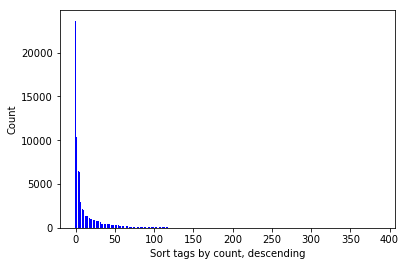

In [8]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

tag_ranks = df[0]
tag_counts= df[1]

N = len(tag_counts)
tag_ranks = range(N)
width = 1/1.5

plt.xlabel("Sort tags by count, descending")
plt.ylabel("Count")
plt.bar(tag_ranks, tag_counts, width, color="blue")

#### Top 10 tags with the highest frequency

In [9]:
df.columns = ['key of tags' ,'count']
print df[0:10]

  key of tags  count
0     highway  23632
1        name  10358
2    building   7665
3          en   6953
4      oneway   6482
5          zh   6329
6       power   2961
7       layer   2879
8      bridge   2398
9      source   2104


### Amenities By Count

sqlite> SELECT value, COUNT(*) AS num
   ...> FROM nodesTags
   ...> WHERE key = 'amenity'
   ...> GROUP BY value
   ...> ORDER BY num DESC;
toilets,198
restaurant,133
shelter,100
post_box,87
bank,69
bus_station,56
fuel,50
fast_food,48
bicycle_parking,42
cafe,39

### Most Popular Cuisines 

sqlite> SELECT value, COUNT(*) AS num
   ...> FROM nodesTags
   ...> WHERE key = 'cuisine'
   ...> GROUP BY value
   ...> ORDER BY num DESC;
chinese,31
burger,12
chinese;fast_food,4
japanese,4
chicken,3
regional,3
vegetarian,3
cantonese,2
local,2
mexican,2
noodle,2
Dumplings,1
coffee_shop,1

## 4. Conclusion

In this project, data cleaning is far from enough.  I only focused on auditing, cleaning the addr:street and addr:city tags.
For example name and building fields contains many records from other city  other than the expected '深圳 Shenzhen'. The audit and fix functions are not applied to clean the data before writing into csv files. I can imagine the challenge in using these approaches to other tags. If the user generated data have standards to follow and auditing tools to improve accuracy and consistancy, the OSM data could be put into broad application. 